In [101]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer 

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import selfies as sf
from rdkit import rdBase
#from rdkit import RDLogger

rdBase.DisableLog('rdApp.*')

In [102]:
idx = 1
model_name = 'VAEProp_obj_w0.1'

### 1. Call Model

In [103]:
folder_path = '../checkpoints/ZINC250K_vae_property_obj_proploss_w0.1/'
config_file = 'vae_property_config.pt'
vocab_file = 'vae_property_vocab.pt'
model_file = 'vae_property_model.pt'

config = torch.load(f'{folder_path}{config_file}')
vocab = torch.load(f'{folder_path}{vocab_file}')

if config.model == 'vae':
    model = VAE(vocab, config)
elif config.model == 'vae_property':
    model = VAEPROPERTY(vocab, config)
    
model.load_state_dict(torch.load(f'{folder_path}{model_file}'))

trainer = VAEPROPERTYTrainer(config)

print(f'use selfies: {config.use_selfies}')



use selfies: False


### 2. Create seed molecules

In [104]:
train_df = pd.read_csv('../moses/dataset/data/ZINC250K/train.csv')
cols = ['logP', 'qed', 'SAS', 'obj']
cols.insert(0, 'SELFIES' if config.use_selfies else 'SMILES')
train_data = train_df[cols].values

size = 1000
np.random.seed(0)
rand_indices = np.random.choice(train_data.shape[0], size, replace=False)
seed_mol = train_data[rand_indices]

#seed_df = pd.DataFrame(seed_mol, columns=['SELFIES' if config.use_selfies else 'SMILES', 'logP', 'qed', 'SAS', 'obj'])
#seed_df.to_csv(f'../results/seed_mol.csv', index=False)

### 3. Encode seed molecules

In [105]:
sample_loader = trainer.get_dataloader(model, seed_mol, shuffle=False)
model.eval()

x_list = []
y_list = []
mu_list = []
logvar_list = []
z_list = []

for step, batch in enumerate(sample_loader):
    x = batch[0]
    y = batch[1]
    x_list.extend(x)
    y_list.extend(np.array(y).squeeze())

    mu, logvar, z, _ = model.forward_encoder(x)
    mu_list.extend(mu.detach().cpu().numpy())
    logvar_list.extend(logvar.detach().cpu().numpy())
    z_list.extend(z.detach().cpu().numpy())

mu_list = np.array(mu_list).squeeze()
logvar_list = np.array(logvar_list).squeeze()
z_list = np.array(z_list).squeeze()

y_list = np.array(y_list).squeeze()
y_list = y_list.reshape(-1, y_list.shape[-1])


In [106]:
whole_data_df = pd.DataFrame(y_list, columns=['logP', 'qed', 'SAS', 'obj'])

whole_data_df.insert(0, 'SELFIES' if config.use_selfies else 'SMILES', [vocab.ids2string(point.detach().cpu().numpy()) for point in x_list])

whole_data_df['mu'] = [point for point in mu_list]
whole_data_df['logvar'] = [point for point in logvar_list]
whole_data_df['z'] = [point for point in z_list]

whole_data_df.to_csv(f'../results/latent_data_{model_name}.csv', index=False)
print(whole_data_df.shape)
whole_data_df.head()

(1000, 8)


,SMILES,logP,qed,SAS,obj,mu,logvar,z
0,NS(=O)(=O)c1ccc2c(c1)C(=O)c1cc(S(N)(=O)=O)ccc1-2,0.19280,0.686905,2.196333,1.238192,"[-0.011870669, -0.014125405, -0.0069034435, 0....","[0.00046276115, 0.0046108775, 0.0010158438, -0...","[-0.17181575, -0.7226793, 0.39638647, 1.236736..."
1,CCn1c(=O)c(=O)[nH]c2cc(C(=O)Nc3ccc(Cl)cc3)ccc21,2.61540,0.716880,1.978275,1.606123,"[-0.01496202, -0.00079067796, -0.0048078597, 0...","[-0.0013600979, 0.0012309826, -0.0017019529, 0...","[-0.35856685, 0.34870112, -0.28122005, -0.3659..."
2,CC(=O)N1CCC2C(CCCN2C(=O)c2cc3cc(C)ccc3[nH]2)C1,2.94932,0.868330,3.097075,1.244576,"[-0.01925852, 0.0027493425, -0.0048666373, 0.0...","[-0.0016398225, 0.0011709137, -0.00082106143, ...","[-0.27106163, -1.427347, 2.5636792, 0.27818787..."
3,Cc1nn(C)c(=O)c(C(=O)Nc2ccc3c(c2)CCC(=O)N3C)c1C,1.55844,0.899021,2.404992,2.090114,"[-0.012613657, 0.003397189, -0.00064240023, 0....","[0.0013285829, 0.0031903416, 3.3030286e-05, 0....","[-0.5414294, -0.009456021, 2.0318005, 1.237013..."
4,CN1CCN(S(=O)(=O)c2cccc(NC(=O)c3cc[nH]n3)c2)CC1,0.59810,0.842118,2.441288,1.769302,"[-0.0038244138, -0.005944304, -0.010004941, 0....","[-0.0004922496, 0.005433159, -0.0025103837, 0....","[-0.2354697, 2.5920935, 0.64547026, 0.97013587..."


#### 3.1. analysis of encoded seed molecules

In [74]:
mu_torch = torch.tensor(whole_data_df['mu'])
logvar_torch = torch.tensor(whole_data_df['logvar'])

z_1 = []
z_2 = []


for j in range(400):
    eps = torch.randn_like(mu_torch[10])
    z = mu_torch[10] + (logvar_torch[10] / 2).exp() * eps
    z_1.append(z)
z_1 = torch.stack(z_1)

eps = torch.randn_like(mu_torch[5])
z = mu_torch[5] + (logvar_torch[5] / 2).exp() * eps
z_2.append(z)
z_2 = torch.stack(z_2)

z_1.shape, z_2.shape

(torch.Size([400, 128]), torch.Size([1, 128]))

In [75]:
np.array(z_1[0].reshape(1, -1) - z_2).reshape(128).shape

(128,)

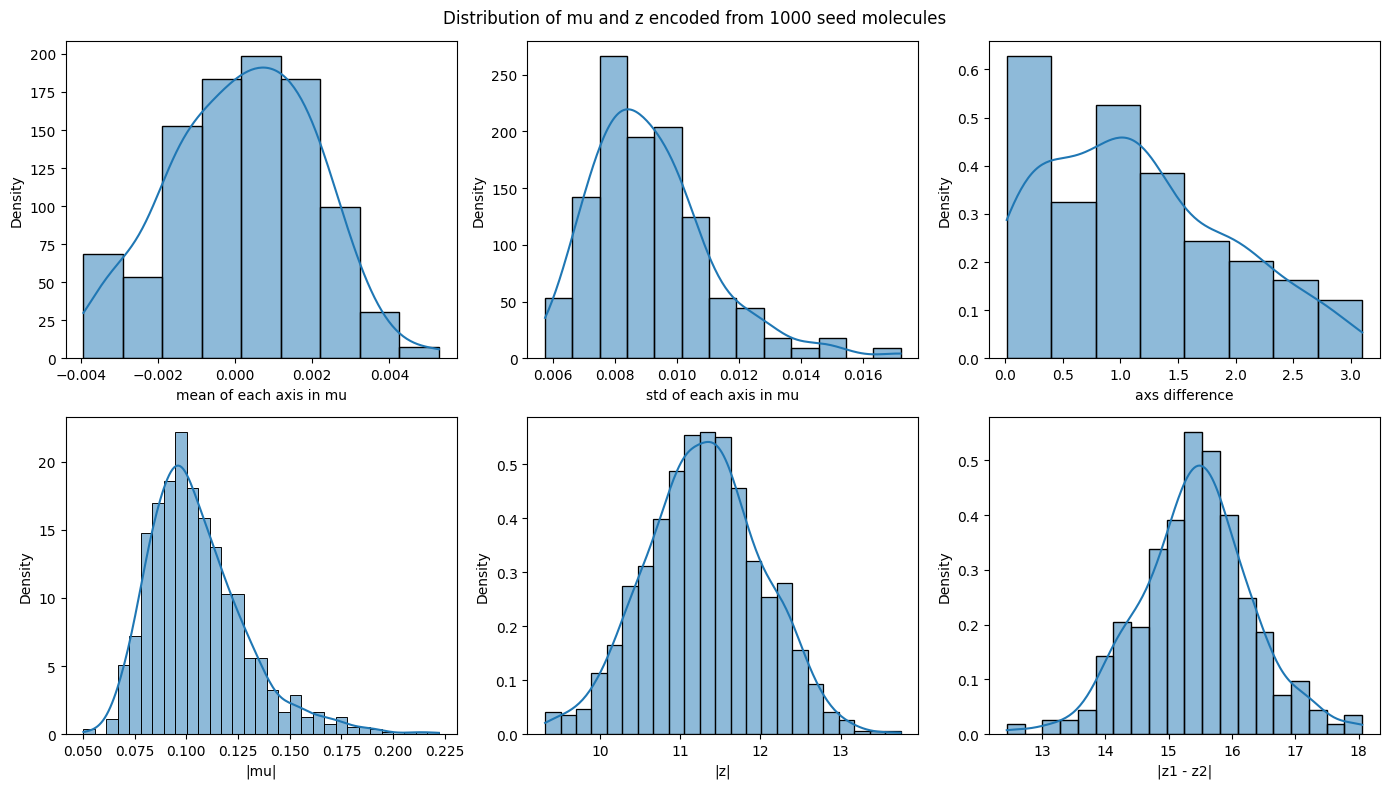

In [127]:
mu_array = np.array(whole_data_df['mu'].tolist())
mu_std = mu_array.std(axis=0)
mu_mean = mu_array.mean(axis=0)
mu_norm = np.linalg.norm(mu_array, axis=1)
z_norm = np.linalg.norm(np.array(whole_data_df['z'].tolist()), axis=1)
z_diff = np.linalg.norm(np.array(z_1 - z_2), axis=1)
#muz_diff = np.linalg.norm((np.array(whole_data_df['mu'] - whole_data_df['z'])).tolist(), axis=1)
axs_diff = np.abs(np.array(z_1[0].reshape(1, -1) - z_2).reshape(128))

fig, axs = plt.subplots(2, 3, figsize=(14, 8))

sns.histplot(mu_mean, ax=axs[0, 0], kde=True, stat='density')
axs[0, 0].set_xlabel('mean of each axis in mu')

sns.histplot(mu_std, ax=axs[0, 1], kde=True, stat='density')
axs[0, 1].set_xlabel('std of each axis in mu')

sns.histplot(mu_norm, ax=axs[1, 0], kde=True, stat='density')
axs[1, 0].set_xlabel('|mu|')

sns.histplot(z_norm, ax=axs[1, 1], kde=True, stat='density')
axs[1, 1].set_xlabel('|z|')

sns.histplot(z_diff, ax=axs[1, 2], kde=True, stat='density')
axs[1, 2].set_xlabel('|z1 - z2|')

sns.histplot(axs_diff, ax=axs[0, 2], kde=True, stat='density')
axs[0, 2].set_xlabel('axs difference')

fig.suptitle('Distribution of mu and z encoded from 1000 seed molecules')
plt.tight_layout()

# save the plot
#plt.savefig(f'../results/latent_dist_{model_name}.png')
plt.show()


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

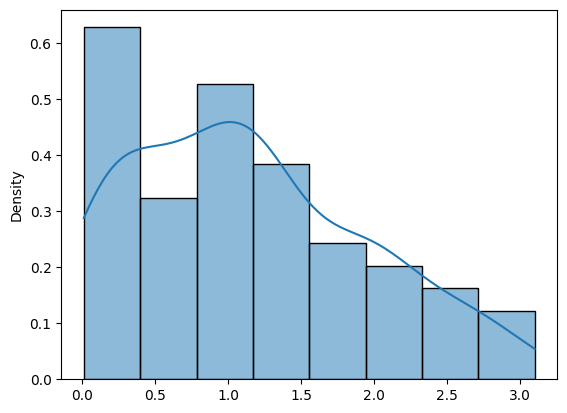

In [129]:
sns.histplot(axs_diff, kde=True, stat='density')
plt.plot

### 4. generate n_attempts samples from each seed molecule

In [107]:
n_attempts = 5
n_gen = len(whole_data_df)*n_attempts
z_calc = []

mu_torch = torch.tensor(whole_data_df['mu'])
logvar_torch = torch.tensor(whole_data_df['logvar'])

for i in range(len(mu_list)):
    for j in range(n_attempts):
        eps = torch.randn_like(mu_torch[i])
        z = mu_torch[i] + (logvar_torch[i] / 2).exp() * eps
        z_calc.append(z)
z_calc = torch.stack(z_calc)

z_calc.shape


torch.Size([5000, 128])

In [108]:
# 실제 mu[0].mean() = -0.0015
# 400개 generate 한 것의 z_calc_mean = 0.0011
# mu[0] - z_calc_mean = -0.0026. 
# 이 정도 수치가 맞는 건가?


In [109]:
batch_size = 400
z_calcs = []
gen = []
for i in range(int(z_calc.shape[0] / batch_size)):
    z_batch = z_calc[i*batch_size:(i+1)*batch_size]
    if i == int(z_calc.shape[0] / batch_size)-1:
        z_batch = z_calc[i*batch_size:]
    gen_batch = model.sample(n_batch=z_batch.shape[0], z=z_batch)
    gen.extend(gen_batch)
    if i % 5 == 0:
        print(f'{i} / {int(z_calc.shape[0] / batch_size)}')

0 / 12
5 / 12
10 / 12


In [110]:
gen_df = pd.DataFrame(gen, columns=['gen_mol'])

if config.use_selfies:
    gen_df.insert(1, 'SMILES', [sf.decoder(point) for point in gen_df['gen_mol']])
    
gen_df['gen_romol'] = [get_mol(mol) for mol in gen_df['SMILES' if config.use_selfies else 'gen_mol']]
gen_df = gen_df.dropna(subset=['gen_romol'])

gen_df['gen_logP'] = [logP(mol) for mol in gen_df['gen_romol']]
gen_df['gen_qed'] = [QED(mol) for mol in gen_df['gen_romol']]
gen_df['gen_SAS'] = [SA(mol) for mol in gen_df['gen_romol']]
gen_df['gen_obj'] = 5*gen_df['gen_qed'] - gen_df['gen_SAS']


In [111]:
gen_df.to_csv(f'../results/sample_gen_{model_name}.csv', index=False)
print(gen_df.shape)
gen_df.head()

(4737, 6)


,gen_mol,gen_romol,gen_logP,gen_qed,gen_SAS,gen_obj
0,CC(C)c1ccc(C2CC2C(=O)N2CCOC3CCCCC32)o1,<rdkit.Chem.rdchem.Mol object at 0x0000027616A...,3.67650,0.853906,3.835273,0.434256
1,CC(C)NC(=O)COC(=O)c1csc(Nc2ccccn2)n1,<rdkit.Chem.rdchem.Mol object at 0x0000027616A...,1.96310,0.790424,2.221479,1.730638
2,O=C(NCC#Cc1ccc(N2CCOCC2)cc1)C1CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x0000027616A...,2.57120,0.868213,2.237364,2.103702
3,COc1ccc(OC)c(-c2[nH]nc3ccc(N)cc23)c1,<rdkit.Chem.rdchem.Mol object at 0x0000027616A...,2.82930,0.716994,2.218874,1.366094
4,CCCCc1nnc(NC(=O)Cc2ccc(C)nc2)s1,<rdkit.Chem.rdchem.Mol object at 0x000002762C7...,2.76532,0.887941,2.190190,2.249514


### 5. evaluate generated samples

In [112]:
gen_metrics = pd.read_csv('../results/gen_metrics.csv')

# gen_metrics = pd.DataFrame(columns=['source', 'data set', 'samples', 'QED_mean', 'QED_std', 'SAS_mean', 'SAS_std', 'logP_mean', 'logP_std', 'obj_mean', 'obj_std'])
# gen_metrics['source'] = ['train Data', 'VAE', 'VAEProperty']
# gen_metrics['data set'] = ['ZINC', 'ZINC', 'ZINC']
# gen_metrics.loc['samples'] = [249000, n_gen]

gen_metrics.loc[idx, 'source'] = model_name
gen_metrics.loc[idx, 'data set'] = 'ZINC'
gen_metrics.loc[idx, 'string'] = 'SELFIES' if config.use_selfies else 'SMILES'
gen_metrics.loc[idx, 'samples'] = n_gen

gen_metrics

,source,data set,string,samples,QED_mean,QED_std,SAS_mean,SAS_std,logP_mean,logP_std,obj_mean,obj_std,valid,unique,% in ZINC moses,% in ZINC250K train,temp unique(1000),seed in temp,arg unique(1000),seed in arg
0,train Data,ZINC,SMILES,249000,0.806452,0.094907,2.449389,0.460109,2.439767,0.927548,1.582869,0.657329,1.0000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN
1,VAEProp_obj_w0.1,ZINC,SMILES,5000,0.810613,0.093205,2.428568,0.456731,2.506032,0.951920,1.624497,0.657816,0.9424,0.998514,22.167906,7.630181,1000.0,False,3.0,True
2,VAEProp_obj_w0.5,ZINC,SMILES,5000,0.809254,0.095182,2.412203,0.454962,2.513439,0.972046,1.634066,0.661516,0.9542,NaN,23.652757,8.702034,1000.0,False,9.0,True
3,SELF_VAEProp_obj_w0.1,ZINC,SELFIES,5000,0.790562,0.121621,2.687221,0.755372,2.459836,0.995696,1.265591,1.074965,1.0000,NaN,15.452362,5.084067,1000.0,False,89.0,True
4,SELF_VAEProp_obj_w0.5,ZINC,SELFIES,5000,0.793239,0.120671,2.623934,0.725834,2.503317,0.989782,1.342260,1.035977,1.0000,0.999400,18.691215,7.324395,1000.0,False,19.0,True


#### 5.1. property distribution

In [113]:
gen_metrics.loc[idx, 'logP_mean'] = [gen_df['gen_logP'].mean()]
gen_metrics.loc[idx, 'logP_std'] = [gen_df['gen_logP'].std()]
gen_metrics.loc[idx, 'QED_mean'] = [gen_df['gen_qed'].mean()]
gen_metrics.loc[idx, 'QED_std'] = [gen_df['gen_qed'].std()]
gen_metrics.loc[idx, 'SAS_mean'] = [gen_df['gen_SAS'].mean()]
gen_metrics.loc[idx, 'SAS_std'] = [gen_df['gen_SAS'].std()]
gen_metrics.loc[idx, 'obj_mean'] = [gen_df['gen_obj'].mean()]
gen_metrics.loc[idx, 'obj_std'] = [gen_df['gen_obj'].std()]

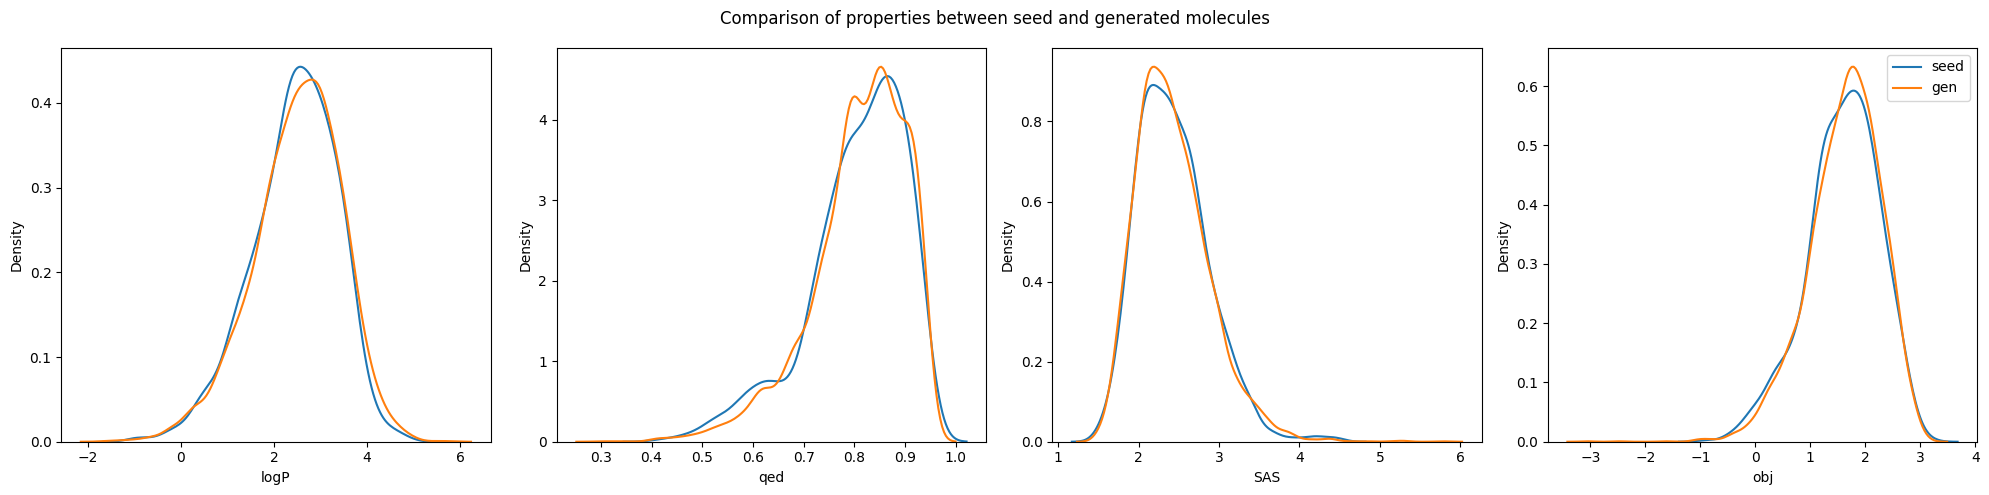

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.kdeplot(whole_data_df['logP'], ax=axs[0], label='seed')
sns.kdeplot(whole_data_df['qed'], ax=axs[1], label='seed')
sns.kdeplot(whole_data_df['SAS'], ax=axs[2], label='seed')
sns.kdeplot(whole_data_df['obj'], ax=axs[3], label='seed')

sns.kdeplot(gen_df['gen_logP'], ax=axs[0], label='gen')
sns.kdeplot(gen_df['gen_qed'], ax=axs[1], label='gen')
sns.kdeplot(gen_df['gen_SAS'], ax=axs[2], label='gen')
sns.kdeplot(gen_df['gen_obj'], ax=axs[3], label='gen')

fig.suptitle('Comparison of properties between seed and generated molecules')
plt.tight_layout()
plt.legend()

plt.savefig(f'../results/gen_prop_dist_{model_name}.png')
plt.show()


#### 5.2. validity

In [84]:
validity = len(gen_df) / n_gen
gen_metrics.loc[idx, 'valid'] = [validity]
print(validity)

1.0


#### 5.3. novelty (% in zinc)

In [19]:
import zipfile
from io import BytesIO

file_path = '../moses/dataset/data/ZINC/'
file_name = 'train.zip'
with zipfile.ZipFile(f'{file_path}{file_name}', 'r') as zip_ref:    
        file = 'train.csv'
        with zip_ref.open(file) as file:
            # Read the CSV file into a pandas DataFrame
            zinc_df= pd.read_csv(BytesIO(file.read()), header=0)

df = pd.read_csv(f'{file_path}test.csv')
df.shape, zinc_df.shape

zinc_df = pd.concat([df, zinc_df], axis=0)

In [20]:
# 고려사항: 어떤 데이터 셋을 기준으로 novelty를 따질 것인가? 
# appeared_zinc: train + test moses data 
# appeared_train: ZINC250K train data
# % emol: purchase needed

col_name = 'SELFIES' if config.use_selfies else 'SMILES'

appeared_zinc = 1 - len(set(gen_df['gen_mol'].values) - set(zinc_df[col_name].values)) / len(set(gen_df['gen_mol']))
appeared_zinc = appeared_zinc * 100
appeared_train = 1 - len(set(gen_df['gen_mol'].values) - set(set(train_data[:, 0]))) / len(set(gen_df['gen_mol']))
appeared_train = appeared_train * 100
# print '% in ZINC moses data: {appeared_zinc}%' with {appeared_zinc} with 2nd decimal point
print(f'% in ZINC moses data: {appeared_zinc:.2f}%')
print(f'% in ZINC250K train data: {appeared_train: .2f}%')

gen_metrics.loc[idx, '% in ZINC moses'] = [appeared_zinc]
gen_metrics.loc[idx, '% in ZINC250K train'] = [appeared_train]

% in ZINC moses data: 22.17%
% in ZINC250K train data:  7.63%


In [22]:
gen_metrics

,source,data set,string,samples,QED_mean,QED_std,SAS_mean,SAS_std,logP_mean,logP_std,obj_mean,obj_std,valid,unique,% in ZINC moses,% in ZINC250K train,temp unique(1000),seed in temp,arg unique(1000),seed in arg
0,train Data,ZINC,SMILES,249000,0.806452,0.094907,2.449389,0.460109,2.439767,0.927548,1.582869,0.657329,1.0000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN
1,VAEProp_obj_w0.1,ZINC,SMILES,5000,0.810613,0.093205,2.428568,0.456731,2.506032,0.951920,1.624497,0.657816,0.9424,NaN,22.167906,7.630181,NaN,NaN,NaN,NaN
2,VAEProp_obj_w0.5,ZINC,SMILES,5000,0.809254,0.095182,2.412203,0.454962,2.513439,0.972046,1.634066,0.661516,0.9542,NaN,23.652757,8.702034,1000.0,False,9.0,True
3,SELF_VAEProp_obj_w0.1,ZINC,SELFIES,5000,0.790562,0.121621,2.687221,0.755372,2.459836,0.995696,1.265591,1.074965,1.0000,NaN,15.452362,5.084067,1000.0,False,89.0,True
4,SELF_VAEProp_obj_w0.5,ZINC,SELFIES,5000,0.793239,0.120671,2.623934,0.725834,2.503317,0.989782,1.342260,1.035977,1.0000,0.9994,18.691215,7.324395,1000.0,False,19.0,True


### ZINC20 dataset

In [22]:
import subprocess

file_path = '../checkpoints/ZINC-downloader-2D-smi.curl'

with open(file_path, 'r') as file:
    commands = file.readlines()

for command in commands:
    command = command.strip()
    if command.startswith('curl'):
        result = subprocess.run(command, shell=True)
        if result.returncode != 0:
            print(f"Failed to execute command: {command}")

Failed to execute command: curl --remote-time --fail --create-dirs -o AA/AACD.smi http://files.docking.org/2D/AA/AACD.smi


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

base_dirs = ['AA', 'AB', 'AC', 'AD', \
             'BA', 'BB', 'BC', 'BD', \
                'CA', 'CB', 'CC', 'CD', \
                    'DA', 'DB', 'DC', 'DD', \
                        'EA', 'EB', 'EC', 'ED', \
                            'FA', 'FB', 'FC', 'FD', \
                                'GA', 'GB', 'GC', 'GD', \
                                    'HA', 'HB', 'HC', \
                                        'IA', 'IB', 'IC', \
                                            'JA', 'JB', 'JC', \
                                                'KA', 'KB', 'KC']  # Adjust based on your directory structure
smi_files = []

# Recursively find all .smi files in the base directory
for base_dir in base_dirs:
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.smi'):
                smi_files.append(os.path.join(root, file))

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame(columns=['SMILES', 'ID'])

# Load each .smi file and append its data to the DataFrame
for smi_file in smi_files:
    data = pd.read_csv(smi_file, delimiter='\t', header=None)
    data.columns = ['SMILES', 'ID']  # Adjust column names as needed
    all_data = pd.concat([all_data, data], ignore_index=True)



In [ ]:
# Process the data (e.g., convert SMILES to RDKit Molecule objects)
all_data['Molecule'] = all_data['SMILES'].apply(Chem.MolFromSmiles)

# Optionally, add molecule images to the DataFrame
#PandasTools.AddMoleculeColumnToFrame(all_data, 'SMILES', 'MoleculeImg')

all_data.to_csv('../results/all_data.csv', index=False)
print(all_data.head())

### 6. 1 seed vs. 1000 samples

#### 6.1. properties

In [114]:
z_calc = []
for j in range(1000):
    eps = torch.randn_like(torch.tensor(whole_data_df['mu'][5]))
    z = torch.tensor(whole_data_df['mu'][5]) + (torch.tensor(whole_data_df['logvar'][5]) / 2).exp() * eps
    z_calc.append(z)
z_calc = torch.stack(z_calc)

sampled = model.sample(n_batch=z_calc.shape[0], z=z_calc, test=False)
sampled = np.array(sampled).squeeze()
sampled_arg = model.sample(n_batch=z_calc.shape[0], z=z_calc, test=True)
sampled_arg = np.array(sampled_arg).squeeze()

In [115]:
seed =model.sample(n_batch=1, z=torch.tensor(whole_data_df['mu'][5].reshape(1, -1)), test=True)
print(f'sampled temp unique: {len(set(sampled))}')
print(f'seed in sampled_temp: {seed[0] in set(sampled)}')
print('\n')
print(f'sampled_arg unique: {len(set(sampled_arg))}')
print(f'seed in sampled_arg: {seed[0] in set(sampled_arg)}')
print(seed[0])
set(sampled_arg)

sampled temp unique: 1000
seed in sampled_temp: False


sampled_arg unique: 3
seed in sampled_arg: True
CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCCC2)cc1


{'CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCCC2)cc1',
 'CC(C)CC(C)N(C)C(=O)CN1CCN(C(=O)C2CCCC2)CC1',
 'CC(C)CC(C)N(C)C(=O)CN1CCN(C(=O)C2CCCCC2)CC1'}

In [117]:
gen_metrics.loc[idx, 'temp unique(1000)'] = len(set(sampled))
gen_metrics.loc[idx, 'seed in temp'] = seed[0] in set(sampled)
gen_metrics.loc[idx, 'arg unique(1000)'] = len(set(sampled_arg))
gen_metrics.loc[idx, 'seed in arg'] = seed[0] in set(sampled_arg)
gen_metrics.loc[idx, 'unique'] = len(gen_df['gen_mol'].unique()) / len(gen_df)
gen_metrics.to_csv('../results/gen_metrics.csv', index=False)

In [ ]:
gen_metrics

,source,data set,string,samples,QED_mean,QED_std,SAS_mean,SAS_std,logP_mean,logP_std,obj_mean,obj_std,valid,unique,% in ZINC moses,% in ZINC250K train,temp unique(1000),seed in temp,arg unique(1000),seed in arg
0,train Data,ZINC,SMILES,249000,0.806452,0.094907,2.449389,0.460109,2.439767,0.927548,1.582869,0.657329,1.0000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN
1,VAEProp_obj_w0.1,ZINC,SMILES,5000,0.810613,0.093205,2.428568,0.456731,2.506032,0.951920,1.624497,0.657816,0.9424,0.998514,22.167906,7.630181,1000.0,False,3.0,True
2,VAEProp_obj_w0.5,ZINC,SMILES,5000,0.809254,0.095182,2.412203,0.454962,2.513439,0.972046,1.634066,0.661516,0.9542,NaN,23.652757,8.702034,1000.0,False,9.0,True
3,SELF_VAEProp_obj_w0.1,ZINC,SELFIES,5000,0.790562,0.121621,2.687221,0.755372,2.459836,0.995696,1.265591,1.074965,1.0000,NaN,15.452362,5.084067,1000.0,False,89.0,True
4,SELF_VAEProp_obj_w0.5,ZINC,SELFIES,5000,0.793239,0.120671,2.623934,0.725834,2.503317,0.989782,1.342260,1.035977,1.0000,0.999400,18.691215,7.324395,1000.0,False,19.0,True


In [118]:
sampled_temp_df = pd.DataFrame(sampled, columns=['gen_mol'])
if config.use_selfies:
    sampled_temp_df['SMILES'] = [sf.decoder(point) for point in sampled_temp_df['gen_mol']]

sampled_temp_df['gen_romol'] = [get_mol(mol) for mol in sampled_temp_df['SMILES' if config.use_selfies else 'gen_mol']]
sampled_temp_df = sampled_temp_df.dropna(subset=['gen_romol'])
sampled_temp_df = sampled_temp_df.reset_index(drop=True)

sampled_temp_df['gen_logP'] = [logP(mol) for mol in sampled_temp_df['gen_romol']]
sampled_temp_df['gen_qed'] = [QED(mol) for mol in sampled_temp_df['gen_romol']]
sampled_temp_df['gen_SAS'] = [SA(mol) for mol in sampled_temp_df['gen_romol']]
sampled_temp_df['gen_obj'] = 5*sampled_temp_df['gen_qed'] - sampled_temp_df['gen_SAS']

In [119]:
sampled_arg_df = pd.DataFrame(sampled_arg, columns=['gen_mol'])
if config.use_selfies:
    sampled_arg_df['SMILES'] = [sf.decoder(point) for point in sampled_arg_df['gen_mol']]
    
sampled_arg_df['gen_romol'] = [get_mol(mol) for mol in sampled_arg_df['SMILES' if config.use_selfies else 'gen_mol']]
sampled_arg_df['gen_z'] = [point for point in z_calc.detach().cpu().numpy()]
sampled_arg_df = sampled_arg_df.dropna(subset=['gen_romol'])
sampled_arg_df = sampled_arg_df.reset_index(drop=True)

sampled_arg_df['gen_logP'] = [logP(mol) for mol in sampled_arg_df['gen_romol']]
sampled_arg_df['gen_qed'] = [QED(mol) for mol in sampled_arg_df['gen_romol']]
sampled_arg_df['gen_SAS'] = [SA(mol) for mol in sampled_arg_df['gen_romol']]
sampled_arg_df['gen_obj'] = 5*gen_df['gen_qed'] - sampled_arg_df['gen_SAS']

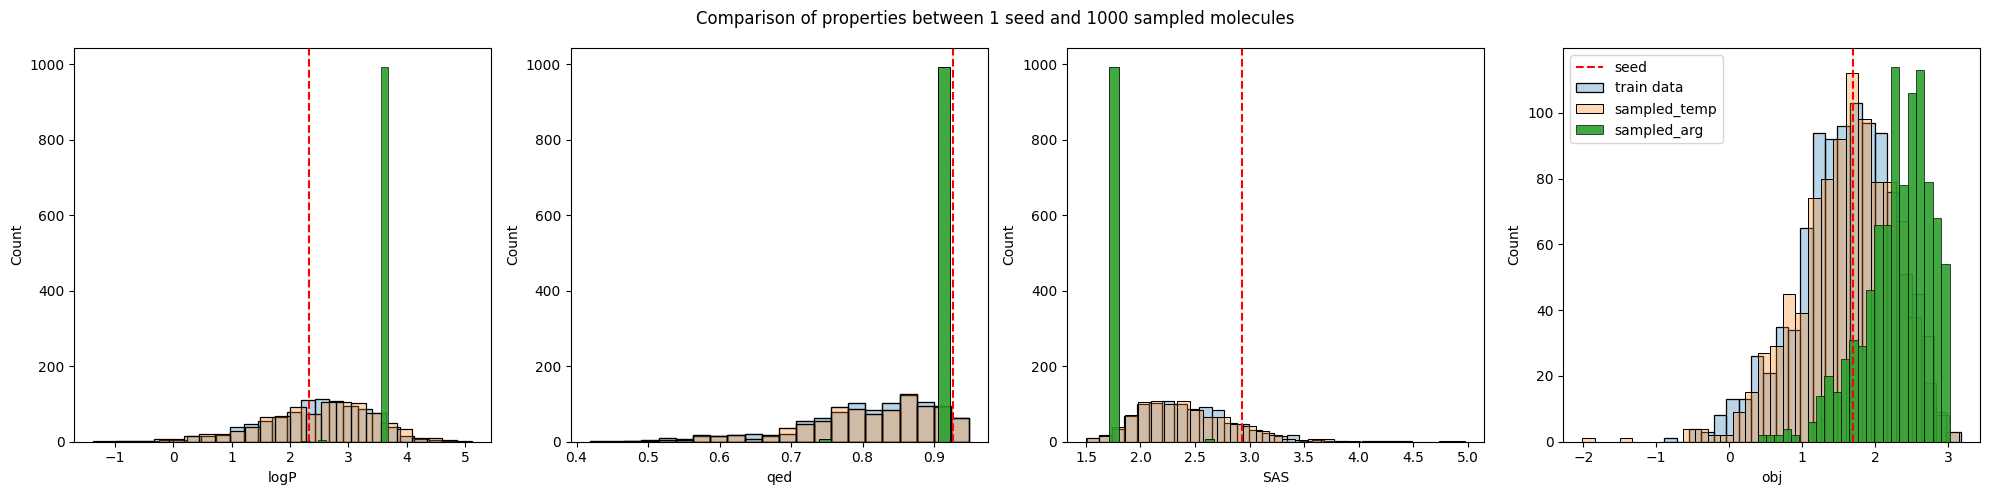

In [120]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.histplot(whole_data_df['logP'], ax=axs[0], label='train data', alpha=0.3)
sns.histplot(whole_data_df['qed'], ax=axs[1], label='train data', alpha=0.3)
sns.histplot(whole_data_df['SAS'], ax=axs[2], label='train data', alpha=0.3) 
sns.histplot(whole_data_df['obj'], ax=axs[3], label='train data', alpha=0.3)

sns.histplot(sampled_temp_df['gen_logP'], ax=axs[0], label='sampled_temp', alpha=0.3)
sns.histplot(sampled_temp_df['gen_qed'], ax=axs[1], label='sampled_temp', alpha=0.3)
sns.histplot(sampled_temp_df['gen_SAS'], ax=axs[2], label='sampled_temp', alpha=0.3)
sns.histplot(sampled_temp_df['gen_obj'], ax=axs[3], label='sampled_temp', alpha=0.3)

sns.histplot(sampled_arg_df['gen_logP'], ax=axs[0], label='sampled_arg', alpha=0.9)
sns.histplot(sampled_arg_df['gen_qed'], ax=axs[1], label='sampled_arg', alpha=0.9)
sns.histplot(sampled_arg_df['gen_SAS'], ax=axs[2], label='sampled_arg', alpha=0.9)
sns.histplot(sampled_arg_df['gen_obj'], ax=axs[3], label='sampled_arg', alpha=0.9)

axs[0].axvline(whole_data_df['logP'][5], color='r', linestyle='--', label='seed')
axs[1].axvline(whole_data_df['qed'][5], color='r', linestyle='--', label='seed')
axs[2].axvline(whole_data_df['SAS'][5], color='r', linestyle='--', label='seed')
axs[3].axvline(whole_data_df['obj'][5], color='r', linestyle='--', label='seed')

fig.suptitle('Comparison of properties between 1 seed and 1000 sampled molecules')
plt.tight_layout()
plt.legend()
plt.savefig(f'../results/sampled_type_prop_{model_name}.png')

plt.show()


#### 6.2. tanimoto similarity
Tanimoto similarity captures the similarity / overlaps of structures between two molecules

If tanimoto similarity = 1 : same molecule

In [91]:
def calculate_tanomoto_similiarity(mol1, mol2):
    fp1 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol1), 2)
    fp2 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol2), 2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [92]:
tanimotos = []
for i in range(len(sampled_temp_df)):
    tanimotos.append(calculate_tanomoto_similiarity(sampled_arg_df['SMILES' if config.use_selfies else 'gen_mol'][0], sampled_arg_df['SMILES' if config.use_selfies else 'gen_mol'][i]))

tanimotos = np.array(tanimotos)

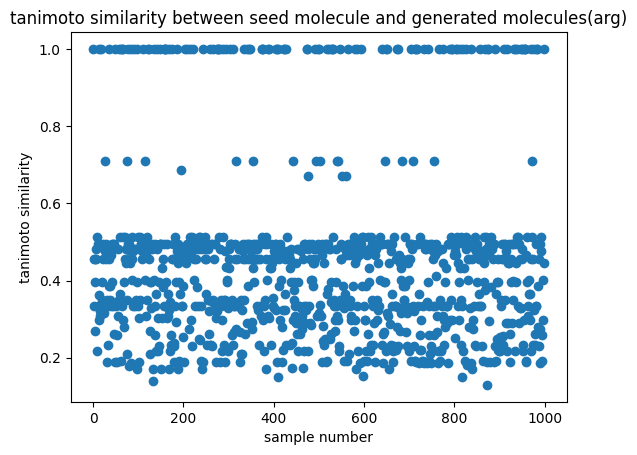

In [93]:
# plot scatter plot of tanimoto similarity
plt.scatter(range(len(tanimotos)), tanimotos)
plt.xlabel('sample number')
plt.ylabel('tanimoto similarity')
plt.title('tanimoto similarity between seed molecule and generated molecules(arg)')
#plt.savefig(f'../results/tanimoto_simil_temp{model_name}.png')
plt.show()

In [121]:
# print number of each unique molecules in sampled_arg_df['gen_mol']
for i in set(sampled_arg_df["gen_mol"]):
    # print number of i in sampled_arg_df['gen_mol']
    print(f'{i}: {len(sampled_arg_df[sampled_arg_df["gen_mol"] == i])}')


CC(C)CC(C)N(C)C(=O)CN1CCN(C(=O)C2CCCCC2)CC1: 4
CC(C)CC(C)N(C)C(=O)CN1CCN(C(=O)C2CCCC2)CC1: 2
CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCCC2)cc1: 994


In [122]:
unique_df = sampled_arg_df.drop_duplicates(subset=['gen_mol'])
unique_df

,gen_mol,gen_romol,gen_z,gen_logP,gen_qed,gen_SAS,gen_obj
0,CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002763FB...,"[-0.8779852, 0.98139286, -1.1594772, -0.882153...",3.6874,0.921890,1.711401,2.558129
216,CC(C)CC(C)N(C)C(=O)CN1CCN(C(=O)C2CCCCC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x000002761A3...,"[0.010852409, 1.5202556, 0.09143859, -1.268904...",2.6039,0.738742,2.674695,1.261078
320,CC(C)CC(C)N(C)C(=O)CN1CCN(C(=O)C2CCCC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x000002761A3...,"[-1.8906765, -0.8362592, -1.6828145, -1.813704...",2.2138,0.746326,2.667700,1.632331


In [123]:
unique_df

,gen_mol,gen_romol,gen_z,gen_logP,gen_qed,gen_SAS,gen_obj
0,CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002763FB...,"[-0.8779852, 0.98139286, -1.1594772, -0.882153...",3.6874,0.921890,1.711401,2.558129
216,CC(C)CC(C)N(C)C(=O)CN1CCN(C(=O)C2CCCCC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x000002761A3...,"[0.010852409, 1.5202556, 0.09143859, -1.268904...",2.6039,0.738742,2.674695,1.261078
320,CC(C)CC(C)N(C)C(=O)CN1CCN(C(=O)C2CCCC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x000002761A3...,"[-1.8906765, -0.8362592, -1.6828145, -1.813704...",2.2138,0.746326,2.667700,1.632331


C:\Users\lisa0\AppData\Local\Temp\ipykernel_27184\3926770710.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['RoMol'] = unique_df['gen_mol']
C:\Users\lisa0\AppData\Local\Temp\ipykernel_27184\3926770710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['RoMol'] = unique_df['RoMol'].apply(Chem.MolFromSmiles)


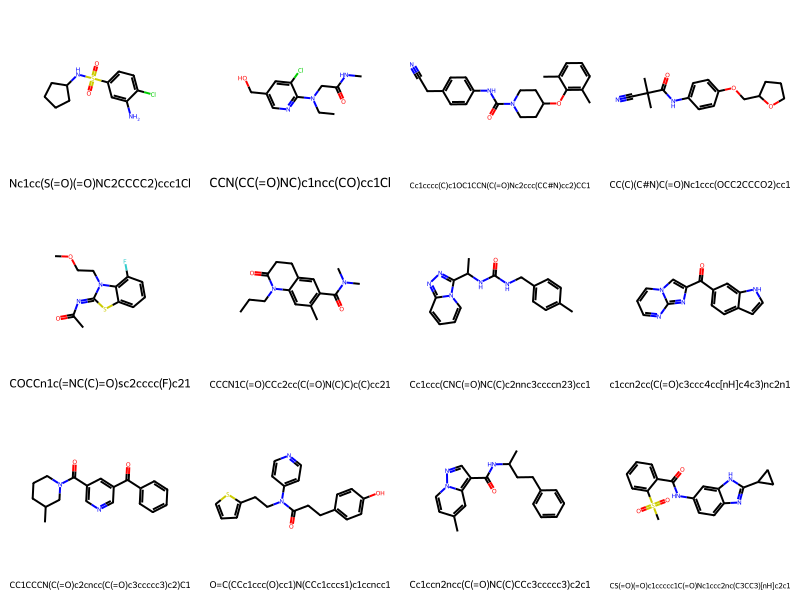

In [126]:
from rdkit.Chem import PandasTools

unique_df = sampled_temp_df[:12]
 
    
unique_df['RoMol'] = unique_df['gen_mol']
unique_df['RoMol'] = unique_df['RoMol'].apply(Chem.MolFromSmiles)
display(PandasTools.FrameToGridImage(unique_df, column='RoMol', legendsCol='gen_mol', molsPerRow=4))
